In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn import datasets
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold

from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


# Features selection

In [2]:

df = pd.read_csv('preprocessed_train_regression.csv')


In [3]:
# Sistemo i dati per regression tree

# One-Hot Encoding 
# nb: pd.get_dummies rimuove le colonne direttamente

# ## StoreId
# df = pd.get_dummies(df, columns=['StoreID'], prefix='StoreID')

df.drop('StoreID',axis=1)

 ## StoreType
df = pd.get_dummies(df, columns=['StoreType'], prefix='StoreType')

 ## AssortmentType
df = pd.get_dummies(df, columns=['AssortmentType'], prefix='AssortmentType')

# ## Region
df = pd.get_dummies(df, columns=['Region'], prefix='Region')

# ## Events
# df = pd.get_dummies(df, columns=['Events'], prefix='Events', dummy_na=True)
### inutile se possiamo usare categorie con decision tree

# numeric features to categories (strings)
#df.StoreID = df.StoreID.astype(str)
#df.Region = df.Region.astype(str)

In [4]:
df.iloc[0]

CloudCover                                           8
Date                                        2016-03-01
DayOfWeek                                            1
Events                                               2
HasPromotions                                        0
IsHoliday                                            0
IsHoliday_tomorrow                                   1
IsHoliday_yesterday                                  1
IsOpen_tomorrow                                      1
IsOpen_yesterday                                     1
Max_Dew_PointC                                       1
Max_Gust_SpeedKm_h                                  21
Max_Humidity                                       100
Max_Sea_Level_PressurehPa                         1032
Max_TemperatureC                                     2
Max_Wind_SpeedKm_h                                  21
Mean_Dew_PointC                                     -1
Mean_Humidity                                       82
Mean_Sea_L

In [5]:
# No-Events (NaN) are considered as sunny days, with lowest value (0) on the events scale
df['Events'] = df['Events'].fillna(0)
df = df.drop('StoreID', axis = 1)

In [6]:
df=df.replace({'Rain':1, 'Thunderstorm':1, 'Fog':1, 'Snow': 2, 'Fog-Rain': 2, 'Rain-Thunderstorm': 2, 'Rain-Snow':2, 'Fog-Snow':2, 'Fog-Rain-Snow':3, 'Rain-Hail':3, 'Snow-Hail':3, 'Rain-Snow-Hail':3, 'Fog-Rain-Hail':3, 'Fog-Thunderstorm':3, 'Fog-Rain-Thunderstorm':4, 'Fog-Snow-Hail':4, 'Fog-Rain-Snow-Hail':4, 'Rain-Snow-Thunderstorm':4, 'Rain-Hail-Thunderstorm':4, 'Fog-Rain-Hail-Thunderstorm':4, 'Rain-Snow-Hail-Thunderstorm':4})

df['Events'].unique()

array([2, 1, 0, 3, 4], dtype=int64)

In [7]:
df = df.drop('Date', axis = 1)

In [8]:
# split trainset in data and target
y = df["NumberOfSales"]
X = df.drop('NumberOfSales', axis=1)

In [9]:
# Looking for features with NaN values
null_cols = []
print('Features with NaN:')
for col in X.columns:
    if X[col].isnull().values.any():
        print(col)
        null_cols.append(col)

Features with NaN:
regression_whole
regression_twomonths


In [10]:
# getting indices (rows) of all NaN values
inds = pd.isnull(X).any(1).nonzero()[0]

In [11]:
# drop all the rows with NaN values
y = y.drop(y.index[inds])
X = X.drop(X.index[inds])

In [12]:
# checking shapes
print('X: ' + str(X.shape))
print('y: ' + str(y.shape))

X: (390642, 55)
y: (390642,)


## Forest-Based features selection

In [13]:
# fit random forest with 250 trees
# forest = ExtraTreesRegressor(n_estimators=250, random_state=0)
forest = RandomForestRegressor(n_estimators=250, random_state=0, n_jobs=-1)
forest.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Feature ranking:
1. feature 34 regression_whole (0.528377)
2. feature 32 month_avg_sales (0.199259)
3. feature 3 HasPromotions (0.099005)
4. feature 36 RegressionDistance (0.018761)
5. feature 29 Week (0.018202)
6. feature 1 DayOfWeek (0.016093)
7. feature 8 IsOpen_yesterday (0.013370)
8. feature 35 regression_twomonths (0.013200)
9. feature 31 daily_sales (0.013068)
10. feature 24 Month (0.009377)
11. feature 25 NearestCompetitor (0.006099)
12. feature 33 yearly_sales (0.005145)
13. feature 21 Min_Humidity (0.003489)
14. feature 7 IsOpen_tomorrow (0.003487)
15. feature 6 IsHoliday_yesterday (0.003271)
16. feature 12 Max_Sea_Level_PressurehPa (0.003193)
17. feature 22 Min_Sea_Level_PressurehPa (0.003121)
18. feature 5 IsHoliday_tomorrow (0.002951)
19. feature 16 Mean_Humidity (0.002938)
20. feature 30 Year (0.002582)
21. feature 17 Mean_Sea_Level_PressurehPa (0.002456)
22. feature 13 Max_TemperatureC (0.002439)
23. feature 19 Mean_Wind_SpeedKm_h (0.002169)
24. feature 23 Min_Temperatur

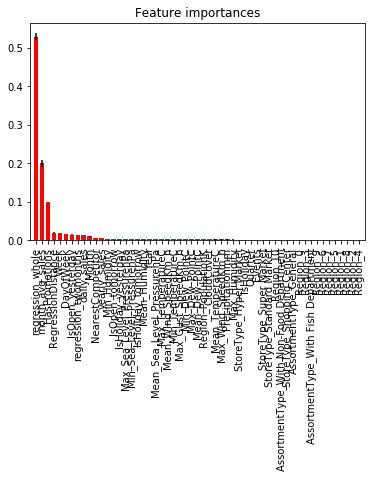

In [14]:
# preso pari pari dal notebook di Lanzi

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices],rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [15]:
feature_selection_model = SelectFromModel(forest, prefit=True)

In [16]:
X_selected_features_forest = feature_selection_model.transform(X)
X_selected_features_forest.shape

(390642, 5)

## PCA features selection

In [17]:
from sklearn.decomposition import PCA
%matplotlib inline

full_pca_model = PCA()
full_fitted_model = full_pca_model.fit(X)

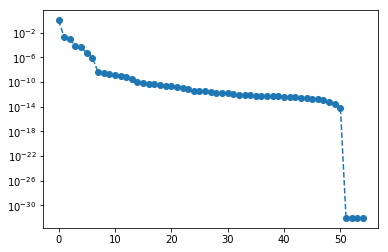

In [18]:
plt.semilogy(full_fitted_model.explained_variance_ratio_, '--o');

Text(0,0.5,'Cumulative Explained Variance Ratio')

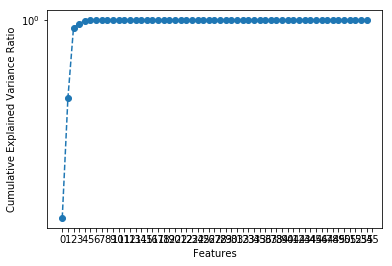

In [19]:
#Looking for a knee on the plot
plt.semilogy(full_fitted_model.explained_variance_ratio_.cumsum(), '--o');
plt.xticks(np.arange(0,56,1));
plt.xlabel("Features")
plt.ylabel("Cumulative Explained Variance Ratio")

In [20]:
# getting Principal (n) Components and reducing the dataset
feature_selection_pca_model = PCA(n_components=5)
fitted_model = feature_selection_pca_model.fit(X)
X_selected_features_pca = fitted_model.transform(X)
print("Explained Variance: %s" % fitted_model.explained_variance_ratio_)
print("Reduced data set shape is ", X_selected_features_pca.shape)

Explained Variance: [9.97208630e-01 1.68686570e-03 9.99721232e-04 5.59292204e-05
 4.31543324e-05]
Reduced data set shape is  (390642, 5)


## Reduced Variance Feature Selection


In [23]:
feature_selection_variance_model = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_selected_features_variance = feature_selection_variance_model.fit_transform(X)

print("Reduced data set shape is ", X_selected_features_variance.shape)

mask = feature_selection_variance_model.get_support() #list of booleans
print("Selected features = ", X.columns[mask])

Reduced data set shape is  (390642, 37)
Selected features =  Index(['CloudCover', 'DayOfWeek', 'Events', 'HasPromotions', 'Max_Dew_PointC',
       'Max_Gust_SpeedKm_h', 'Max_Humidity', 'Max_Sea_Level_PressurehPa',
       'Max_TemperatureC', 'Max_Wind_SpeedKm_h', 'Mean_Dew_PointC',
       'Mean_Humidity', 'Mean_Sea_Level_PressurehPa', 'Mean_TemperatureC',
       'Mean_Wind_SpeedKm_h', 'Min_Dew_PointC', 'Min_Humidity',
       'Min_Sea_Level_PressurehPa', 'Min_TemperatureC', 'Month',
       'NearestCompetitor', 'Precipitationmm', 'Quarter', 'Region_PopulationK',
       'Week', 'Year', 'daily_sales', 'month_avg_sales', 'yearly_sales',
       'regression_whole', 'regression_twomonths', 'RegressionDistance',
       'StoreType_Hyper Market', 'StoreType_Standard Market',
       'AssortmentType_General', 'AssortmentType_With Non-Food Department',
       'Region_9'],
      dtype='object')


## Univariate Feature Selection 


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

feature_selection_univariate_model = SelectKBest(mutual_info_regression, k=4)
X_selected_features_univariate = feature_selection_univariate_model.fit_transform(X,y)
print("Reduced data set shape is ",X_selected_features_univariate.shape)

mask = feature_selection_univariate_model.get_support() #list of booleans
print("Selected features = ",X.columns[mask])